<a href="https://colab.research.google.com/github/Kshn12017/Emotion-detection/blob/main/Emotion_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split


# Step 1: Load the dataset from CSV
data = pd.read_csv('/content/drive/MyDrive/TCS/resampled_dataset.csv')

sentences = data['sentence'].tolist()
emotions = data['emotion'].tolist()

                                            sentence  emotion
0  dannycastillo We want to trade with someone wh...  neutral
1                                   cant fall asleep  neutral
2  No Topic Maps talks at the Balisage Markup Con...  neutral
3                           cynthia_123 i cant sleep  neutral
4                    I missed the bl***y bus!!!!!!!!  neutral
-----------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120932 entries, 0 to 120931
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  120932 non-null  object
 1   emotion   120932 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None
-----------------------------------------------------------------------------------------------------------------
                                                 sentence  emotion
count                 

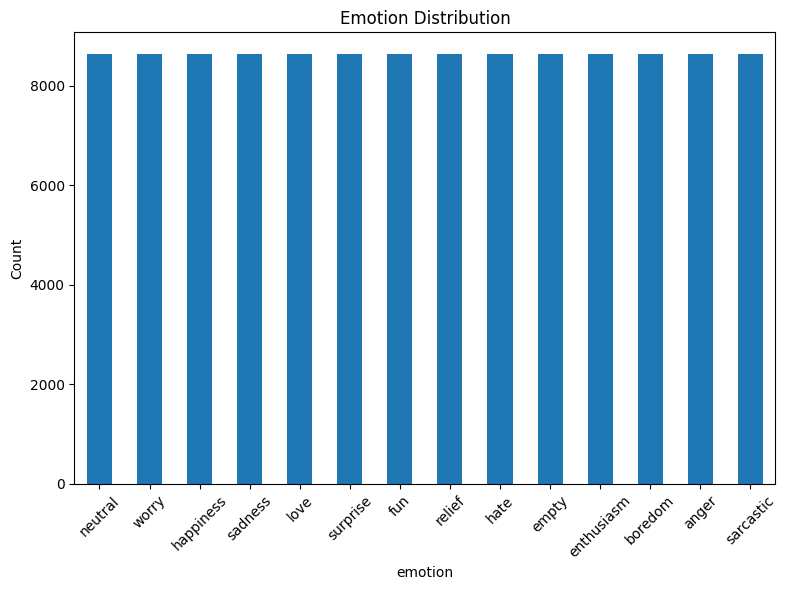

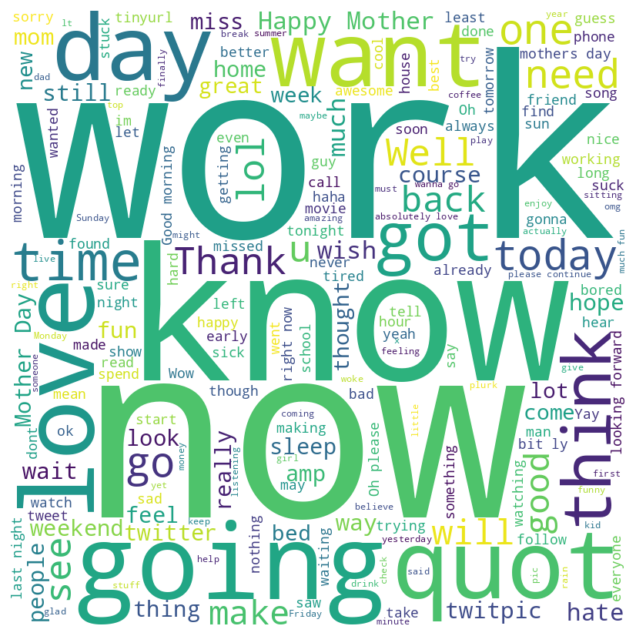

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Display first few rows of the dataset
print(data.head())
print("-----------------------------------------------------------------------------------------------------------------")

# Overview of data types and missing values
print(data.info())
print("-----------------------------------------------------------------------------------------------------------------")

# Summary statistics of numerical columns
print(data.describe())
print("-----------------------------------------------------------------------------------------------------------------")

# Create count plots for categorical columns
categorical_columns = ['emotion']  # Add your categorical columns here
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    data[col].value_counts().plot(kind='bar')
    plt.title(f'Emotion Distribution')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create a word cloud for text data
text_data = ' '.join(data['sentence'])  # Assuming 'sentence' is the text column
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text_data)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Step 2: Preprocess the text
def resolve_double_negation(sentence):
    # Pattern to match double negations
    pattern = r"\b(?:not|n't)\s+\b(?:no|never|nobody|nothing|none|nowhere)\b"

    # Replace double negations with positive counterparts
    resolved_sentence = re.sub(pattern, ' ', sentence)
    return resolved_sentence

# Apply double negation resolution to each sentence
sentences = [resolve_double_negation(sentence) for sentence in sentences]
sentences = [sentence.lower() for sentence in sentences]

# Convert abbreviations to their full forms
abbreviations = {
    'nxt': 'next',
    '2mrw': 'tomorrow',
    'r': 'are',
    'gd': 'good',
    'ig': 'i guess',
    'idk': 'i dont know',
    'lol': 'laughing out loud',
    'omg': 'oh my god',
    'btw': 'by the way',
    'brb' : 'be right back',
    'afk' : 'away from keyboard',
    'fyi' : 'for your information',
    'idk' : 'i dont know',
    'tbh' : 'to be honest',
    'imo' : 'in my opinion',
    'imho' : 'in my humble opinion',
    'rofl' : 'rolling on the floor laughing',
    'lmao' : 'laughing my ass off',
    'tmi' : 'too much information',
    'afaik' : 'as far as i know',
    'nvm' : 'never mind',
    'jk' : 'just kidding',
    'asap' : 'as soon as possible',
    'fyr' : 'for your reference',
    'eta' : 'estimated time of arrival',
    'fwiw' : 'for what its worth'
}

for i in range(len(sentences)):
    sentence = sentences[i]
    for abbreviation, full_form in abbreviations.items():
        sentence = sentence.replace(abbreviation, full_form)
    sentences[i] = sentence.lower()

In [ ]:
# Step 3: Tokenize and encode the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(sentences)
max_sequence_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Step 4: Prepare the labels
# Convert emotions to one-hot encoding
emotions_mapping = {
    'anger': 0,
    'boredom': 1,
    'empty': 2,
    'enthusiasm': 3,
    'fun': 4,
    'happiness': 5,
    'hate': 6,
    'love': 7,
    'neutral': 8,
    'relief': 9,
    'sadness': 10,
    'surprise': 11,
    'worry': 12,
    'sarcastic': 13
}

labels = [emotions_mapping[emotion] for emotion in emotions]
one_hot_labels = tf.keras.utils.to_categorical(labels)

# Split the data into training and testing sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=0)

In [ ]:
# Step 5: Define the sarcasm detection model
sarcasm_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

sarcasm_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def check_sarcasm(sentence):
    input_ids = sarcasm_tokenizer.encode(sentence, truncation=True, padding=True, max_length=128, return_tensors='tf')
    predictions = sarcasm_model(input_ids)[0]
    predicted_label = tf.argmax(predictions, axis=1).numpy()[0]
    labels = ['Non-sarcastic', 'Sarcastic']
    sarcasm_label = labels[predicted_label]
    return sarcasm_label

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 6: Define the emotion detection model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(14, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Step 7: Train the emotion detection model
model.fit(train_sentences, train_labels, epochs=10, batch_size=32)

Epoch 1/10
1003/1003 [==============================] - 215s 200ms/step - loss: 2.0297 - accuracy: 0.3008
Epoch 2/10
1003/1003 [==============================] - 186s 186ms/step - loss: 1.7550 - accuracy: 0.4098
Epoch 3/10
1003/1003 [==============================] - 191s 190ms/step - loss: 1.3689 - accuracy: 0.5461
Epoch 4/10
1003/1003 [==============================] - 190s 190ms/step - loss: 0.9575 - accuracy: 0.6981
Epoch 5/10
1003/1003 [==============================] - 192s 191ms/step - loss: 0.6538 - accuracy: 0.7969
Epoch 6/10
1003/1003 [==============================] - 193s 192ms/step - loss: 0.4543 - accuracy: 0.8584
Epoch 7/10
1003/1003 [==============================] - 190s 189ms/step - loss: 0.3324 - accuracy: 0.8974
Epoch 8/10
1003/1003 [==============================] - 191s 190ms/step - loss: 0.2648 - accuracy: 0.9176
Epoch 9/10
1003/1003 [==============================] - 185s 185ms/step - loss: 0.2127 - accuracy: 0.9329
Epoch 10/10
1003/1003 [=======================

In [ ]:
# Step 8: Predict emotions for new sentences
def predict_emotion(sentence):
    preprocessed_sentence = sentence.lower()
    sequence = tokenizer.texts_to_sequences([preprocessed_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)[0]
    emotion_index = np.argmax(prediction)
    predicted_emotion = list(emotions_mapping.keys())[emotion_index]

    # Check for sarcasm and predict emotion accordingly
    sarcasm_label = check_sarcasm(sentence)
    if sarcasm_label == 'Sarcastic' and predicted_emotion != 'Sarcastic':
        predicted_emotion = 'Sarcastic'

    return predicted_emotion

In [ ]:
# Step 9: Evaluate the model on the testing set
loss, accuracy = model.evaluate(test_sentences, test_labels)

print(f"Test Accuracy: {accuracy:.4f}")

251/251 [==============================] - 13s 50ms/step - loss: 1.0157 - accuracy: 0.8185
Test Accuracy: 0.8185


In [ ]:
sentence = "It was a good experiene.."
emotion = predict_emotion(sentence)
print(f"Emotion: {emotion}")

1/1 [==============================] - 0s 195ms/step
Emotion: happiness
